In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.onnx
import onnxruntime as ort
import matplotlib.pyplot as plt

# Load the datasets
df_trfcomplexity = pd.read_csv("data prep/meta_learningdata/final_dataframe_trfcomplexity.csv")
df_acas = pd.read_csv("data prep/meta_learningdata/final_acas_data.csv")

# Feature Engineering for TRF Complexity Data
df_trfcomplexity['FLT_DATE'] = pd.to_datetime(df_trfcomplexity['FLT_DATE'])
df_trfcomplexity['Quarter'] = df_trfcomplexity['FLT_DATE'].dt.quarter

# Handling non-numeric values for ACAS Dataset
print("Handling non-numeric values for ACAS Dataset...")
df_acas['Latitude'] = pd.to_numeric(df_acas['Latitude'], errors='coerce')
df_acas['Longitude'] = pd.to_numeric(df_acas['Longitude'], errors='coerce')
df_acas['Altitude'] = pd.to_numeric(df_acas['Altitude'], errors='coerce')
df_acas['Vertical Speed'] = pd.to_numeric(df_acas['Vertical Speed'], errors='coerce')
print("Handling non-numeric values for ACAS Dataset completed.")

# Drop rows with NaN values
print("Dropping rows with NaN values...")
df_acas.dropna(subset=['Latitude', 'Longitude'], inplace=True)
print("NaN values dropped.")

# Risk Zones for ACAS Data
high_risk_zone_bounds = {'lat_min': 30, 'lat_max': 40, 'long_min': -100, 'long_max': -90}
df_acas['High_Risk_Zone'] = ((df_acas['Latitude'] >= high_risk_zone_bounds['lat_min']) &
                             (df_acas['Latitude'] <= high_risk_zone_bounds['lat_max']) &
                             (df_acas['Longitude'] >= high_risk_zone_bounds['long_min']) &
                             (df_acas['Longitude'] <= high_risk_zone_bounds['long_max'])).astype(int)

# Flight Condition Categories for ACAS Data
df_acas['Altitude_Category'] = pd.cut(df_acas['Altitude'], bins=[0, 5000, 10000, 15000, df_acas['Altitude'].max()],
                                      labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)
df_acas['Vertical_Speed_Category'] = pd.cut(df_acas['Vertical Speed'], bins=[df_acas['Vertical Speed'].min(), -500, 500, df_acas['Vertical Speed'].max()],
                                            labels=['Rapid Descent', 'Stable', 'Rapid Ascent'], include_lowest=True)

# Combine features from both datasets
combined_features = pd.concat([df_trfcomplexity.drop(['FLT_DATE'], axis=1),
                               pd.get_dummies(df_acas.drop(['Latitude', 'Longitude'], axis=1))], axis=1)



# Create a synthetic target variable for demonstration
y = np.random.randint(0, 2, size=len(combined_features))
# Checking for NaN values in combined_features
if combined_features.isnull().any().any():
    print("NaN values detected in combined features. Handling...")
    
    
    combined_features.dropna(inplace=True)
    print("Rows with NaN values have been dropped.")

    
y = y[combined_features.index]


Handling non-numeric values for ACAS Dataset...
Handling non-numeric values for ACAS Dataset completed.
Dropping rows with NaN values...
NaN values dropped.
NaN values detected in combined features. Handling...
Rows with NaN values have been dropped.


In [2]:

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.1, random_state=42)

# Split the data while preserving indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    combined_features, y, range(len(combined_features)), test_size=0.2, random_state=42
) 

# Correctly extract test set rows based on integer positions from 'test_indices'
test_geodata = df_acas.iloc[test_indices]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [3]:


# Training loop
model = SimpleNN(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

# for epoch in range(epochs):
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs.squeeze(), labels)
#         loss.backward()
#         optimizer.step()
        
            
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)

#         #  output is flattened without removing necessary dimensions
#         outputs = outputs.view(-1)

#         # Calculate loss
#         loss = criterion(outputs, labels)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#     print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
# Training loop
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # Check the range of outputs
        print(f"Min value in outputs: {outputs.min().item()}, Max value in outputs: {outputs.max().item()}")
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
          print("NaN or Inf found in outputs")
        #break
        #  outputs are flattened and remain within the [0, 1] range
        outputs = outputs.view(-1)
        

        #  labels are float type
        labels = labels.float()
        
      

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    



# Convert to ONNX
dummy_input = torch.randn(1, X_train.shape[1])
torch.onnx.export(model, dummy_input, "data prep/meta_learningdata/accident_prediction.onnx")
print("model created.")

# Re-export the ONNX model with the correct dummy input
dummy_input = torch.randn(1, X_train.shape[1])
torch.onnx.export(model, dummy_input, "data prep/meta_learningdata/accident_prediction.onnx")
print("ONNX model re-exported.")

import onnx

# Load and verify the ONNX model
onnx_model = onnx.load("data prep/meta_learningdata/accident_prediction.onnx")
input_shape = onnx_model.graph.input[0].type.tensor_type.shape.dim
print("ONNX model input shape:", [dim.dim_value for dim in input_shape])




Min value in outputs: 0.3233654201030731, Max value in outputs: 0.5677983164787292
Min value in outputs: 0.3502058982849121, Max value in outputs: 0.5648062229156494
Min value in outputs: 0.37554019689559937, Max value in outputs: 0.5891314148902893
Min value in outputs: 0.35681936144828796, Max value in outputs: 0.5763858556747437
Min value in outputs: 0.3621954321861267, Max value in outputs: 0.6104826331138611
Min value in outputs: 0.3268921673297882, Max value in outputs: 0.6569058895111084
Min value in outputs: 0.3805851340293884, Max value in outputs: 0.6637501120567322
Min value in outputs: 0.3701004385948181, Max value in outputs: 0.6347858905792236
Min value in outputs: 0.3155360221862793, Max value in outputs: 0.7013756036758423
Min value in outputs: 0.33380720019340515, Max value in outputs: 0.6957959532737732
Min value in outputs: 0.36592671275138855, Max value in outputs: 0.6258620619773865
Min value in outputs: 0.18430183827877045, Max value in outputs: 0.6579483151435852

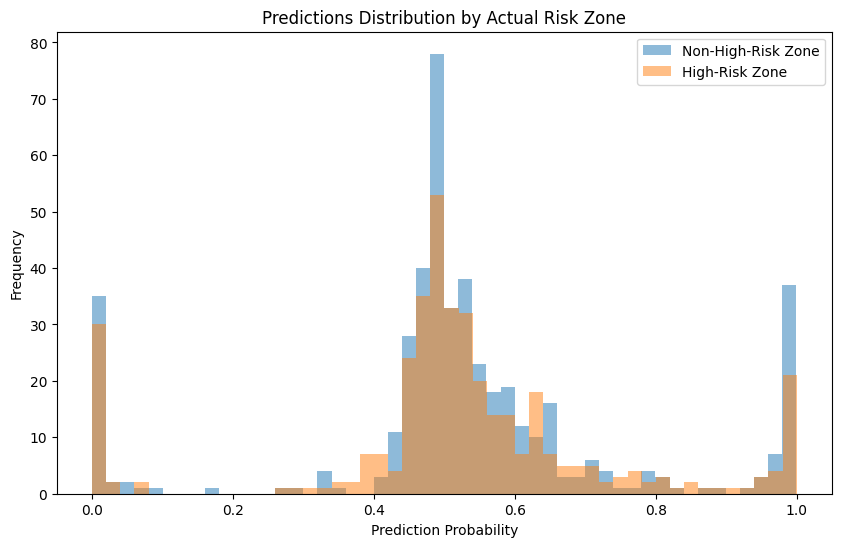

In [4]:
import numpy as np
import onnxruntime as ort
# Load the ONNX model
ort_session = ort.InferenceSession('data prep/meta_learningdata/accident_prediction.onnx')

# Function to preprocess and predict for a single sample
def preprocess_and_predict(sample, ort_session):
    # Reshape the sample to match the model's input shape
    sample_reshaped = sample.reshape(1, -1)  # Reshaping to (1, 7860)

    # Prepare the input for the ONNX model
    ort_inputs = {ort_session.get_inputs()[0].name: sample_reshaped.astype(np.float32)}

    # Run inference
    ort_outs = ort_session.run(None, ort_inputs)

    return ort_outs[0]  

# Iterate over each sample in X_test_scaled and make predictions
predictions = [preprocess_and_predict(X_test_scaled[i], ort_session) for i in range(X_test_scaled.shape[0])]

#  flatten the list of predictions
predictions_flattened = np.concatenate(predictions, axis=0)

# predictions_flattened will now contain the model's predictions for each sample

# Results Plotting
plt.figure(figsize=(10, 6))
plt.hist(predictions_flattened[y_test == 0], bins=50, alpha=0.5, label='Non-High-Risk Zone')
plt.hist(predictions_flattened[y_test == 1], bins=50, alpha=0.5, label='High-Risk Zone')
plt.title('Predictions Distribution by Actual Risk Zone')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

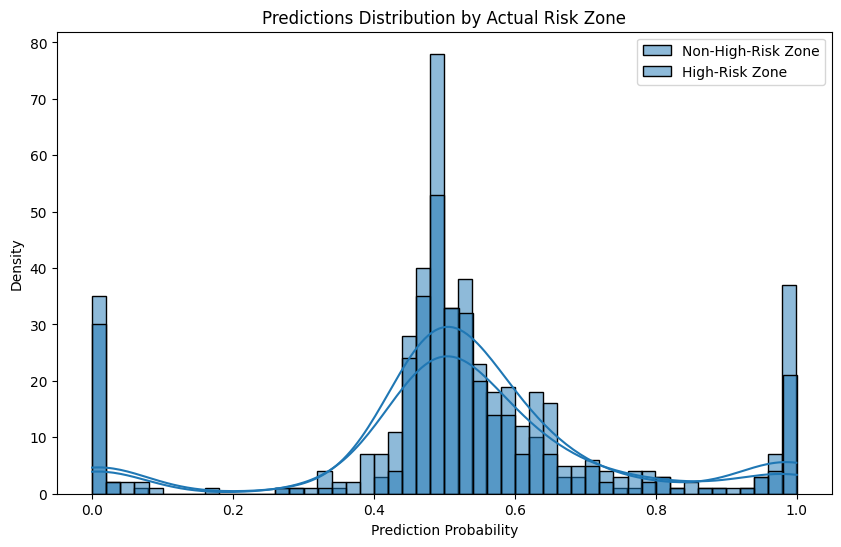

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Enhanced Histogram
plt.figure(figsize=(10, 6))
sns.histplot(predictions_flattened[y_test == 0], bins=50, kde=True, color="blue", alpha=0.5, label='Non-High-Risk Zone')
sns.histplot(predictions_flattened[y_test == 1], bins=50, kde=True, color="red", alpha=0.5, label='High-Risk Zone')
plt.title('Predictions Distribution by Actual Risk Zone')
plt.xlabel('Prediction Probability')
plt.ylabel('Density')
plt.legend()
plt.show()


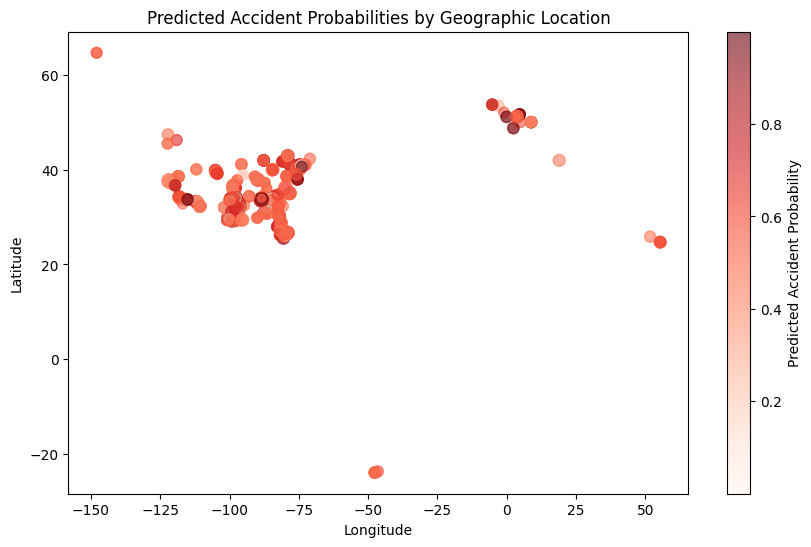

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [10]:
# Extract geographic data corresponding to X_test entries
test_geodata = df_acas.iloc[test_indices][['Latitude', 'Longitude', 'Vertical Speed']]

# Normalize 'Vertical Speed' for visualization purposes
speeds_normalized = (test_geodata['Vertical Speed'] - test_geodata['Vertical Speed'].min()) / (test_geodata['Vertical Speed'].max() - test_geodata['Vertical Speed'].min()) * 100 + 10

# Visualization
plt.figure(figsize=(10, 6))
sc = plt.scatter(test_geodata['Longitude'], test_geodata['Latitude'], c=predictions_flattened, cmap='Reds', s=speeds_normalized, alpha=0.6)
plt.colorbar(sc, label='Predicted Accident Probability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Accident Probabilities by Geographic Location')
plt.show()




In [18]:
accident_probability_threshold = 0.1
high_risk_points = []

for index, (lat, long, speed, prediction) in enumerate(zip(test_geodata['Latitude'], test_geodata['Longitude'], test_geodata['Vertical Speed'], predictions_flattened)):
    # prediction is treated as a scalar
    prediction_value = prediction if np.isscalar(prediction) else prediction[0]
    
    if prediction_value > accident_probability_threshold:
        print(f"High-Risk Point {index + 1}: Latitude={lat}, Longitude={long}, Vertical Speed={speed}, Predicted Accident Probability={prediction_value:.4f}")
        high_risk_points.append((lat, long, speed, prediction_value))


#  high_risk_points is a numpy array for easier manipulation
high_risk_points = np.array(high_risk_points)

# Check if there are any high-risk points
if len(high_risk_points) > 0:
    plt.figure(figsize=(10, 6))
    
    # Normalize 'Vertical Speed' for high-risk points
    speeds_normalized = (high_risk_points[:, 2] - high_risk_points[:, 2].min()) / (high_risk_points[:, 2].max() - high_risk_points[:, 2].min()) * 100 + 10
    

High-Risk Point 1: Latitude=33.539724, Longitude=-99.715445, Vertical Speed=-1600.0, Predicted Accident Probability=0.4389
High-Risk Point 2: Latitude=35.922733, Longitude=-80.120603, Vertical Speed=64.0, Predicted Accident Probability=0.5209
High-Risk Point 3: Latitude=29.609024, Longitude=-100.237726, Vertical Speed=-1920.0, Predicted Accident Probability=0.6446
High-Risk Point 4: Latitude=26.140411, Longitude=-80.246214, Vertical Speed=0.0, Predicted Accident Probability=0.5927
High-Risk Point 5: Latitude=36.059689, Longitude=-98.905062, Vertical Speed=-64.0, Predicted Accident Probability=0.5788
High-Risk Point 6: Latitude=33.42524, Longitude=-112.020581, Vertical Speed=nan, Predicted Accident Probability=0.9969
High-Risk Point 7: Latitude=39.2204, Longitude=-104.409851, Vertical Speed=-768.0, Predicted Accident Probability=0.5928
High-Risk Point 8: Latitude=51.7072, Longitude=4.661026, Vertical Speed=-192.0, Predicted Accident Probability=0.9041
High-Risk Point 9: Latitude=37.4482

<Figure size 1000x600 with 0 Axes>

High-Risk Point 2: Latitude=35.922733, Longitude=-80.120603, Vertical Speed=64.0, Predicted Accident Probability=0.5209
High-Risk Point 4: Latitude=26.140411, Longitude=-80.246214, Vertical Speed=0.0, Predicted Accident Probability=0.5927
High-Risk Point 5: Latitude=36.059689, Longitude=-98.905062, Vertical Speed=-64.0, Predicted Accident Probability=0.5788
High-Risk Point 8: Latitude=51.7072, Longitude=4.661026, Vertical Speed=-192.0, Predicted Accident Probability=0.9041
High-Risk Point 9: Latitude=37.448203, Longitude=-121.951466, Vertical Speed=-192.0, Predicted Accident Probability=0.4588
High-Risk Point 10: Latitude=30.223342, Longitude=-82.214923, Vertical Speed=0.0, Predicted Accident Probability=0.4851
High-Risk Point 11: Latitude=33.658218, Longitude=-88.418641, Vertical Speed=-320.0, Predicted Accident Probability=0.4643
High-Risk Point 12: Latitude=33.962357, Longitude=-99.575594, Vertical Speed=1088.0, Predicted Accident Probability=0.5831
High-Risk Point 14: Latitude=33.7

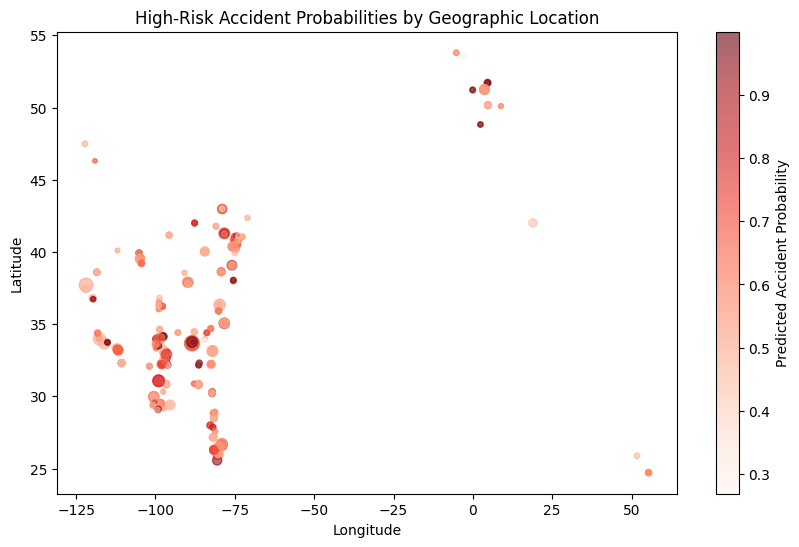

In [24]:
accident_probability_threshold = 0.1
min_latitude_threshold = 10  
min_vertical_speed_threshold = -500  

high_risk_points = []

for index, (lat, long, speed, prediction) in enumerate(zip(test_geodata['Latitude'], test_geodata['Longitude'], test_geodata['Vertical Speed'], predictions_flattened)):
    #  prediction is treated as a scalar
    prediction_value = prediction if np.isscalar(prediction) else prediction[0]
    
    # Apply the additional filters
    if prediction_value > accident_probability_threshold and lat > min_latitude_threshold and speed > min_vertical_speed_threshold:
        print(f"High-Risk Point {index + 1}: Latitude={lat}, Longitude={long}, Vertical Speed={speed}, Predicted Accident Probability={prediction_value:.4f}")
        high_risk_points.append((lat, long, speed, prediction_value))
    
    

# Convert high-risk points to a numpy array for easier manipulation
high_risk_points = np.array(high_risk_points)

# Visualization
if len(high_risk_points) > 0:
    plt.figure(figsize=(10, 6))
    speeds_normalized = (high_risk_points[:, 2] - high_risk_points[:, 2].min()) / (high_risk_points[:, 2].max() - high_risk_points[:, 2].min()) * 100 + 10
    
    sc = plt.scatter(high_risk_points[:, 1], high_risk_points[:, 0], c=high_risk_points[:, 3], cmap='Reds', s=speeds_normalized, alpha=0.6)
    plt.colorbar(sc, label='Predicted Accident Probability')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('High-Risk Accident Probabilities by Geographic Location')
    


    plt.show()
else:
    print("No high-risk accident locations found meeting all criteria.")


C:\Users\Admin\AppData\Local\Temp\ipykernel_28996\3843681182.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  mayday_scatter = plt.scatter(mayday_points[:, 1], mayday_points[:, 0], c='red', s=mayday_points[:, 1] * 10 + 100, marker='+', edgecolor='k', label='MaydayMaydayMayday')


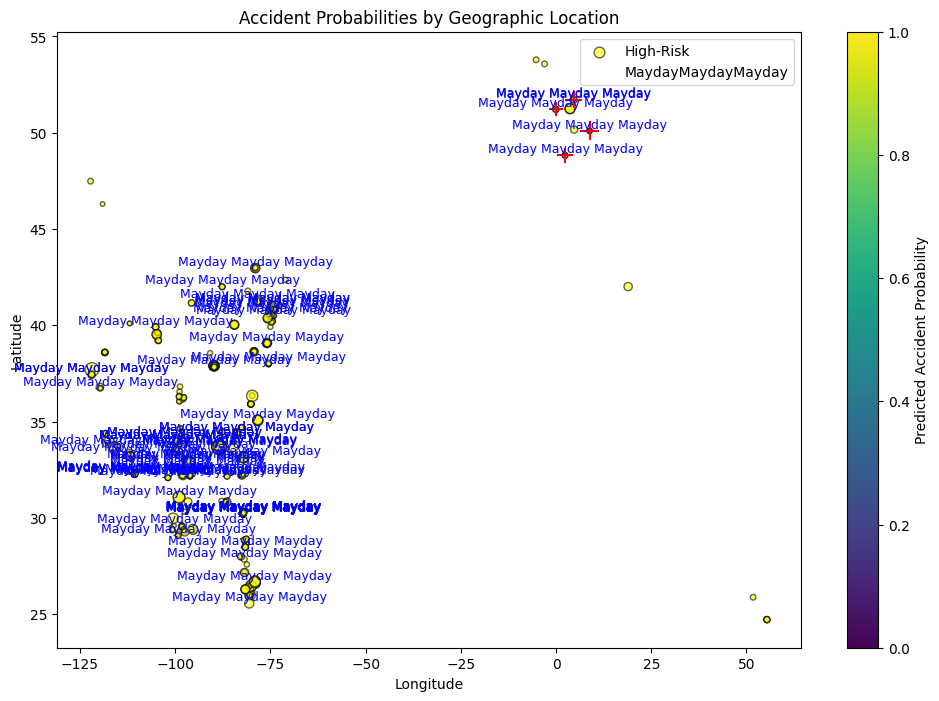

C:\Users\Admin\AppData\Local\Temp\ipykernel_28996\3843681182.py:61: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(mayday_points[:, 1], mayday_points[:, 0], c='red', s=30, marker='+', edgecolor='k', label='MaydayMaydayMayday (' + str(mayday_count) + ')')


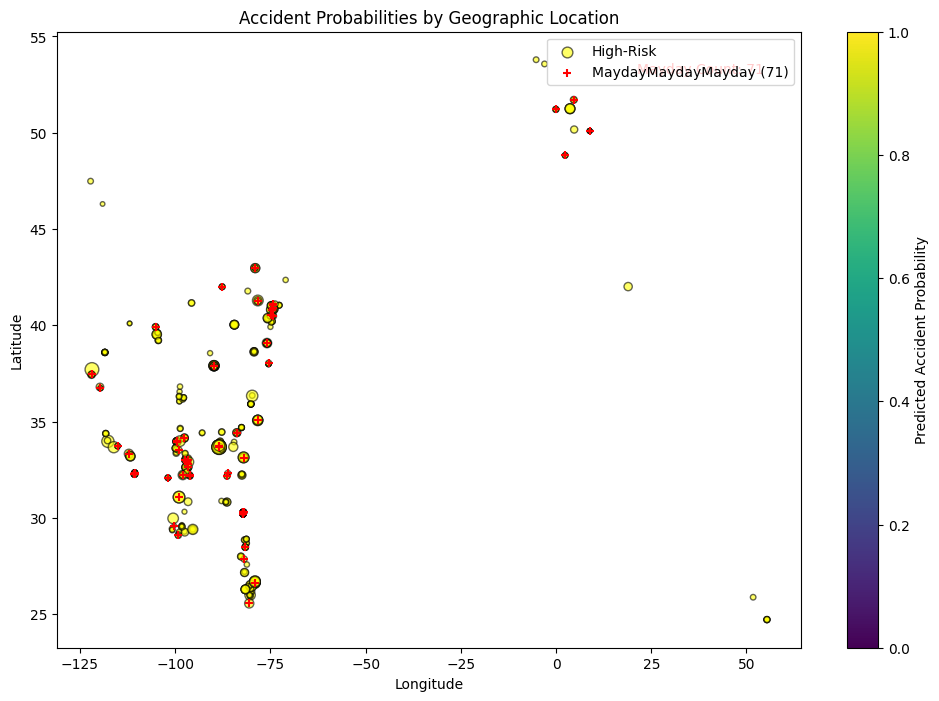

Total number of Mayday Mayday Mayday Message points: 71


In [33]:
# Thresholds for filtering points
accident_probability_threshold = 0.1
mayday_threshold = 0.8  # Critical condition threshold
min_latitude_threshold = 10  # Minimum latitude threshold
min_vertical_speed_threshold = -500  # Minimum vertical speed threshold

high_risk_points = []
mayday_points = []

# Filter points based on thresholds
for index, (lat, long, speed, prediction) in enumerate(zip(test_geodata['Latitude'], test_geodata['Longitude'], test_geodata['Vertical Speed'], predictions_flattened)):
    prediction_value = prediction if np.isscalar(prediction) else prediction[0]
    
    # Apply additional filters for high-risk points
    if prediction_value > accident_probability_threshold and lat > min_latitude_threshold and speed > min_vertical_speed_threshold:
        high_risk_points.append((lat, long, speed, prediction_value))
        
        # Further identify "Mayday" points
        if prediction_value > mayday_threshold:
            mayday_points.append((lat, long, speed, prediction_value))

# Convert lists to numpy arrays for easier manipulation
high_risk_points = np.array(high_risk_points)
mayday_points = np.array(mayday_points)

# Visualization
plt.figure(figsize=(12, 8))

# Plot high-risk points
if len(high_risk_points) > 0:
    speeds_normalized = (high_risk_points[:, 2] - high_risk_points[:, 2].min()) / (high_risk_points[:, 2].max() - high_risk_points[:, 2].min()) * 100 + 10
    plt.scatter(high_risk_points[:, 1], high_risk_points[:, 0], c='yellow', s=speeds_normalized, alpha=0.6, edgecolor='k', label='High-Risk')

# Highlight "Mayday" points distinctly and add annotations
if len(mayday_points) > 0:
    mayday_scatter = plt.scatter(mayday_points[:, 1], mayday_points[:, 0], c='red', s=mayday_points[:, 1] * 10 + 100, marker='+', edgecolor='k', label='MaydayMaydayMayday')
    
    # Annotate "Mayday Mayday Mayday" for each critical point
    for i, (x, y) in enumerate(zip(mayday_points[:, 1], mayday_points[:, 0])):
        plt.text(x, y, "Mayday Mayday Mayday", fontsize=9, color='blue', ha='center', va='bottom')

plt.colorbar(label='Predicted Accident Probability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accident Probabilities by Geographic Location')
plt.legend()
plt.show()


# Visualization
plt.figure(figsize=(12, 8))

# Plot high-risk points
if len(high_risk_points) > 0:
    speeds_normalized = (high_risk_points[:, 2] - high_risk_points[:, 2].min()) / (high_risk_points[:, 2].max() - high_risk_points[:, 2].min()) * 100 + 10
    plt.scatter(high_risk_points[:, 1], high_risk_points[:, 0], c='yellow', s=speeds_normalized, alpha=0.6, edgecolor='k', label='High-Risk')

# Highlight "Mayday" points distinctly and count them
mayday_count = len(mayday_points)
if mayday_count > 0:
    plt.scatter(mayday_points[:, 1], mayday_points[:, 0], c='red', s=30, marker='+', edgecolor='k', label='MaydayMaydayMayday (' + str(mayday_count) + ')')

    # Optional: Display the count on the plot
    plt.text(0.95, 0.95, 'Mayday Count: ' + str(mayday_count), ha='right', va='top', transform=plt.gca().transAxes, color='red')

plt.colorbar(label='Predicted Accident Probability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accident Probabilities by Geographic Location')
plt.legend()
plt.show()

# Additionally, print the count directly in the output
print("Total number of Mayday Mayday Mayday Message points:", mayday_count)
